# IMPACT paper experiments
### 1. Init
#### 1.1. Import libraries (necessary)

In [2]:
%load_ext autoreload
%autoreload 2

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from liriscat import utils
utils.set_seed(0)
from liriscat import dataset
from liriscat import selectionStrategy
from liriscat import CDM

import logging
import gc
import json
import torch
import pandas as pd
from importlib import reload
import IMPACT

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA is not available. Skipping CUDA seed setting.


/home/arthurb/Programmation/liriscat/y/envs/liriscat-env/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


#### 1.2. Set up the loggers (recommended)

In [2]:
utils.setuplogger(verbose = True, log_name="liriscat")

### 2. CDM prediction
#### 2.1. Training and testing, sequential version

In [3]:
import warnings
import numpy as np

gc.collect()
torch.cuda.empty_cache()

reload(utils)
reload(selectionStrategy)
reload(CDM)
reload(dataset)

<module 'liriscat.dataset' from '/home/arthurb/Programmation/liriscat/liriscat/dataset/__init__.py'>

In [4]:
config = utils.generate_eval_config(load_params=True, esc = 'error', valid_metric= 'mi_acc', pred_metrics = ["mi_acc"], profile_metrics = ['doa'], save_params=False, n_query=4, num_epochs=4, batch_size=512)
utils.set_seed(config["seed"])

config["dataset_name"] = "math2"
logging.info(config["dataset_name"])
config['learning_rate'] = 0.02026
config['lambda'] = 1.2e-5
config['d_in'] = 4
config['num_responses'] = 12
#pred_metrics,df_interp = test(config)

CUDA is available. Using GPU.
[INFO 01:07] math2


In [5]:
logging.info(f'#### {config["dataset_name"]} ####')
logging.info(f'#### config : {config} ####')
config['embs_path']='../embs/'+str(config["dataset_name"])
config['params_path']='../ckpt/'+str(config["dataset_name"])

pred_metrics = {m:[] for m in config['pred_metrics']}
profile_metrics = {m:[] for m in config['profile_metrics']}

gc.collect()
torch.cuda.empty_cache()

# Dataset downloading for doa and rm
warnings.filterwarnings("ignore", message="invalid value encountered in divide")
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Concept map format : {question_id : [category_id1, category_id2, ...]}
concept_map = json.load(open(f'../datasets/2-preprocessed_data/{config["dataset_name"]}_concept_map.json', 'r'))
concept_map = {int(k): [int(x) for x in v] for k, v in concept_map.items()}

## Metadata map format : {"num_user_id": ..., "num_item_id": ..., "num_dimension_id": ...}
metadata = json.load(open(f'../datasets/2-preprocessed_data/{config["dataset_name"]}_metadata.json', 'r'))

[INFO 01:07] #### math2 ####
[INFO 01:07] #### config : {'seed': 0, 'dataset_name': 'math2', 'load_params': True, 'save_params': False, 'embs_path': '../embs/', 'params_path': '../ckpt/', 'early_stopping': True, 'esc': 'error', 'verbose_early_stopping': False, 'disable_tqdm': False, 'valid_metric': 'mi_acc', 'learning_rate': 0.02026, 'batch_size': 512, 'valid_batch_size': 10000, 'num_epochs': 4, 'eval_freq': 1, 'patience': 30, 'device': device(type='cuda'), 'lambda': 1.2e-05, 'tensorboard': False, 'flush_freq': True, 'pred_metrics': ['mi_acc'], 'profile_metrics': ['doa'], 'num_responses': 12, 'low_mem': False, 'n_query': 4, 'CDM': 'impact', 'i_fold': 0, 'd_in': 4} ####


In [6]:
i_fold = 0
## Dataframe columns : (user_id, question_id, response, category_id)
train_df = pd.read_csv(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_train_{i_fold}.csv',
    encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                             "dimension_id": int})
valid_df = pd.read_csv(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_valid_{i_fold}.csv',
    encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                             "dimension_id": int})
test_df = pd.read_csv(
    f'../datasets/2-preprocessed_data/{config["dataset_name"]}_test_{i_fold}.csv',
    encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                             "dimension_id": int})

In [7]:
reload(dataset)
train_data = dataset.CATDataset(train_df, concept_map, metadata, config)
valid_data = dataset.EvalDataset(valid_df, concept_map, metadata, config)
test_data = dataset.EvalDataset(test_df, concept_map, metadata, config)

/home/arthurb/Programmation/liriscat/liriscat/dataset/dataset.py:183: UserWarning: The torch_array contains both query and the meta set !
  warnings.warn("The torch_array contains both query and the meta set !")
/home/arthurb/Programmation/liriscat/liriscat/dataset/dataset.py:188: UserWarning: The log_tensor contains both query and the meta set !
  warnings.warn("The log_tensor contains both query and the meta set !")


In [8]:
reload(utils)
reload(selectionStrategy)
reload(dataset)
reload(CDM)

S = selectionStrategy.Random(metadata, **config)


[INFO 01:11] Random_cont_model


In [9]:
from IMPACT.model import IMPACT

In [10]:
IMPACT.model.IMPACT.resp_to_mod()

In [10]:
S.init_models(train_data, valid_data)

In [11]:
S.evaluate_test(test_data)

/home/arthurb/Programmation/liriscat/liriscat/dataset/dataset.py:188: UserWarning: The log_tensor contains both query and the meta set !
  warnings.warn("The log_tensor contains both query and the meta set !")
/home/arthurb/Programmation/liriscat/liriscat/dataset/dataset.py:193: UserWarning: The user_dict contains both query and the meta set !
  warnings.warn("The user_dict contains both query and the meta set !")


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 3.71 GiB of which 194.00 MiB is free. Process 15277 has 1.41 GiB memory in use. Including non-PyTorch memory, this process has 148.00 MiB memory in use. Of the allocated memory 40.12 MiB is allocated by PyTorch, and 17.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [23]:

S.train(train_data, valid_data)

[INFO 50:23] train on cuda
[INFO 50:23] -- START Training --


/home/arthurb/Programmation/liriscat/liriscat/selectionStrategy/random.py:39: UserWarning: get_params() Notimplemented
  warnings.warn('get_params() Notimplemented')
/home/arthurb/Programmation/liriscat/liriscat/dataset/dataset.py:188: UserWarning: The log_tensor contains both query and the meta set !
  warnings.warn("The log_tensor contains both query and the meta set !")
/home/arthurb/Programmation/liriscat/liriscat/dataset/dataset.py:193: UserWarning: The user_dict contains both query and the meta set !
  warnings.warn("The user_dict contains both query and the meta set !")
  0%|          | 0/4 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
data_loader = torch.utils.data.DataLoader(impact_valid_data, batch_size=1, shuffle=False)

In [ ]:
U_resp_sum = torch.zeros(size=(S.CDM.model.user_n, S.CDM.model.concept_n)).to(S.device, non_blocking=True)
U_resp_nb = torch.zeros(size=(S.CDM.model.user_n, S.CDM.model.concept_n)).to(S.device, non_blocking=True)

S.CDM.model.eval()
with torch.no_grad(), torch.amp.autocast('cuda'):
    data_loader = torch.utils.data.DataLoader(impact_valid_data, batch_size=1, shuffle=False)
    for data_batch in data_loader:
        user_ids = data_batch[:, 0].long()
        item_ids = data_batch[:, 1].long()
        labels = data_batch[:, 2]
        dim_ids = data_batch[:, 3].long()

        U_resp_sum[user_ids, dim_ids] += labels
        U_resp_nb[user_ids, dim_ids] += torch.ones_like(labels)

In [ ]:
S.CDM.init_model(impact_train_data, impact_valid_data)
S.CDM.model.to(S.device, non_blocking=True)
S.CDM.train(train_data, valid_data)


In [ ]:
test_data.split_query_meta(2)
S.evaluate_test(test_data)

In [9]:
saved_mi_acc = [0.567, 0.584, 0.597, 0.612, 0.625, 0.645, 0.657, 0.683]
KLI_mi_acc = [0.587, 0.6149999999999999, 0.645, 0.661, 0.6679999999999999, 0.675, 0.6890000000000001, 0.7010000000000001]



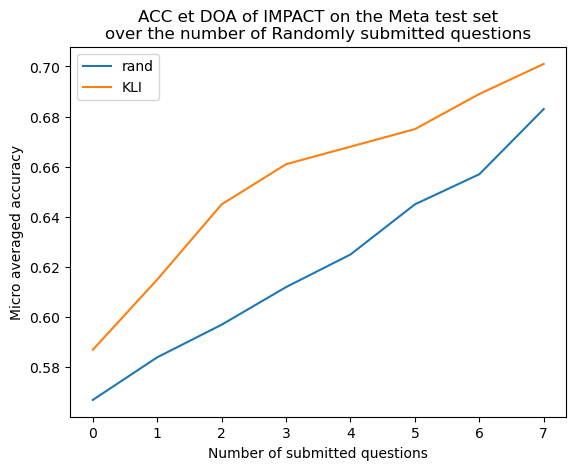

In [12]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# First plot
color1 = 'b'
ln1 = ax1.plot(saved_mi_acc, label='rand')
ln2 = ax1.plot(KLI_mi_acc, label='KLI')
ax1.set_xlabel('Number of submitted questions')
ax1.set_ylabel('Micro averaged accuracy')
ax1.tick_params(axis='y')
ax1.legend()


plt.title('ACC et DOA of IMPACT on the Meta test set\nover the number of Randomly submitted questions')
plt.show()
